In [7]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib

### Results
##### FINAL_BASE_DATASET_WITH_BETS_ZEROS_REMOVED_WITH_SEASON
###### Training 2014/2015 --> 51.22%
max_depth = 3,
min_child_weight = 8,
gamma = 4.3,
colsample_bytree = 0.7,
subsample = 0.75,
reg_alpha = 1e-5

###### Training 2013 - 2015 --> 51.13%

max_depth = 3,
min_child_weight = 5,
gamma = 3.4,
colsample_bytree = 1,
subsample = 0.9,
reg_alpha = 1e-5

###### Training all data --> 50.18%

max_depth = 6,
min_child_weight = 4,
gamma = 1.4,
colsample_bytree = 1,
subsample = 0.5,
reg_alpha = 1e-5


In [9]:
#dataset = "FINAL_BASE_DATASET_WITH_BETS_WITH_SEASON"
#dataset = "FINAL_BASE_DATASET_TEAM_RATINGS_WITH_NO_ZEROS_ADDED_NO_BETS_AGE_BMI_ZEROS_NOT_REMOVED_WITH_SEASON"
dataset = "FINAL_BASE_DATASET_WITH_BETS_ZEROS_REMOVED_WITH_SEASON"
#dataset = "FINAL_BASE_DATASET_WITH_SEASON"

data = pd.read_csv("./../Preprocessing/Data_Structures/{}.csv".format(dataset), index_col=0)


data_train = data[(data["season"] == "2014/2015")]#|(data["season"] == "2013/2014")]
#data_train = data[data["season"] != "2015/2016"]
data_test = data[data["season"] == "2015/2016"]

y_train = data_train.Label
X_train = data_train.drop("Label", axis = 1)
X_train = X_train.drop("season", axis = 1)
y_test = data_test.Label
X_test = data_test.drop("Label", axis = 1)
X_test = X_test.drop("season", axis = 1)

#max_depth = 6, min_child_weight = 6, 0.01, 672: 0.494873817035
def get_xgb_params():
    params = {}
    params['objective'] = 'multi:softmax'
    params['silent'] = 0
        
    #params['learning_rate'], params['n_estimators'] = 0.1, 92
    #params['learning_rate'], params['n_estimators'] = 0.05, 209
    #params['learning_rate'], params['n_estimators'] = 0.01, 210
    
    params['learning_rate'], params['n_estimators'] = 0.005, 74
    params['max_depth'], params['min_child_weight'] = 3,8
    params['gamma'] = 4.3
    params['colsample_bytree'], params['subsample'] = 0.7,0.75
    params['reg_alpha'] = 1e-5
    return params

In [205]:
xgbm = xgb.XGBClassifier(**get_xgb_params())
xgtrain = xgb.DMatrix(X_train, label=y_train)
params = xgbm.get_xgb_params()
params['num_class'] = 3
cvresult = xgb.cv(params, xgtrain, num_boost_round=10000, nfold=10, metrics='merror', early_stopping_rounds=50, verbose_eval=True)

print np.min(cvresult)

[0]	train-merror:0.450549+0.00764429	test-merror:0.478541+0.0262646
[1]	train-merror:0.448784+0.00666412	test-merror:0.474678+0.0351408
[2]	train-merror:0.450358+0.00626223	test-merror:0.469528+0.0294359
[3]	train-merror:0.447878+0.00425349	test-merror:0.46824+0.0300093
[4]	train-merror:0.449404+0.00551696	test-merror:0.463948+0.0278442
[5]	train-merror:0.448879+0.0051849	test-merror:0.463949+0.0283033
[6]	train-merror:0.448927+0.00550058	test-merror:0.467811+0.0260357
[7]	train-merror:0.448689+0.00478035	test-merror:0.466953+0.0285852
[8]	train-merror:0.447973+0.00399661	test-merror:0.46867+0.0278011
[9]	train-merror:0.449118+0.00447749	test-merror:0.46824+0.0283685
[10]	train-merror:0.448832+0.00435376	test-merror:0.466524+0.0292382
[11]	train-merror:0.448593+0.00440185	test-merror:0.466094+0.0293733
[12]	train-merror:0.449356+0.00373088	test-merror:0.466094+0.0294984
[13]	train-merror:0.448116+0.00466281	test-merror:0.464378+0.0308776
[14]	train-merror:0.448212+0.00409917	test-merro

In [183]:
params = {
    #'max_depth' : range(1,8,1),
    #'min_child_weight' : range(1,10,1)
    #'gamma':np.linspace(0,5,26)
    'subsample':np.linspace(0.5,1,6),
    'colsample_bytree':np.linspace(0.5,1,6),    
    #'reg_alpha':np.concatenate(([1e-5,1e-4,1e-3], (np.linspace(0,5,11))))
    #'learning_rate' : np.linspace(0.12,0.18,7)
}

xgb_model = xgb.XGBClassifier(**get_xgb_params())
gscv = GridSearchCV(xgb_model, params, n_jobs=1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True),
                   verbose=2, refit=True, scoring='accuracy')
gscv.fit(X_train, y_train)

gscv.grid_scores_, gscv.best_score_, gscv.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] subsample=0.5, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.5, total=   1.9s
[CV] subsample=0.5, colsample_bytree=0.5 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .............. subsample=0.5, colsample_bytree=0.5, total=   1.8s
[CV] subsample=0.5, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.5, total=   2.9s
[CV] subsample=0.5, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.5, total=   2.5s
[CV] subsample=0.5, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.5, total=   2.3s
[CV] subsample=0.6, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.6, colsample_bytree=0.5, total=   2.4s
[CV] subsample=0.6, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.6, colsample_bytree=0.5, total=   2.3s
[CV] subsample=0.6, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.6, colsample_bytree=0.5, total=   2.4s
[CV] subsample=0.6, colsample_bytree=0.5 .............................
[CV] .

[CV] .............. subsample=1.0, colsample_bytree=0.6, total=   2.9s
[CV] subsample=0.5, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.7, total=   3.0s
[CV] subsample=0.5, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.7, total=   2.7s
[CV] subsample=0.5, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.7, total=   3.2s
[CV] subsample=0.5, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.7, total=   3.7s
[CV] subsample=0.5, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.7, total=   3.6s
[CV] subsample=0.6, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.6, colsample_bytree=0.7, total=   3.0s
[CV] subsample=0.6, colsample_bytree=0.7 .............................
[CV] .

[CV] .............. subsample=1.0, colsample_bytree=0.8, total=   3.1s
[CV] subsample=1.0, colsample_bytree=0.8 .............................
[CV] .............. subsample=1.0, colsample_bytree=0.8, total=   3.3s
[CV] subsample=1.0, colsample_bytree=0.8 .............................
[CV] .............. subsample=1.0, colsample_bytree=0.8, total=   3.8s
[CV] subsample=0.5, colsample_bytree=0.9 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.9, total=   3.4s
[CV] subsample=0.5, colsample_bytree=0.9 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.9, total=   3.2s
[CV] subsample=0.5, colsample_bytree=0.9 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.9, total=   3.4s
[CV] subsample=0.5, colsample_bytree=0.9 .............................
[CV] .............. subsample=0.5, colsample_bytree=0.9, total=   3.3s
[CV] subsample=0.5, colsample_bytree=0.9 .............................
[CV] .

[CV] .............. subsample=1.0, colsample_bytree=1.0, total=   3.6s
[CV] subsample=1.0, colsample_bytree=1.0 .............................
[CV] .............. subsample=1.0, colsample_bytree=1.0, total=   3.4s
[CV] subsample=1.0, colsample_bytree=1.0 .............................
[CV] .............. subsample=1.0, colsample_bytree=1.0, total=   3.3s
[CV] subsample=1.0, colsample_bytree=1.0 .............................
[CV] .............. subsample=1.0, colsample_bytree=1.0, total=   3.4s
[CV] subsample=1.0, colsample_bytree=1.0 .............................
[CV] .............. subsample=1.0, colsample_bytree=1.0, total=   4.3s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  9.9min finished
/Users/steeve/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.56242, std: 0.00368, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: 0.56301, std: 0.00380, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.5},
  mean: 0.56272, std: 0.00409, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.5},
  mean: 0.56161, std: 0.00426, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.5},
  mean: 0.56323, std: 0.00389, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.5},
  mean: 0.56397, std: 0.00358, params: {'subsample': 1.0, 'colsample_bytree': 0.5},
  mean: 0.56441, std: 0.00313, params: {'subsample': 0.5, 'colsample_bytree': 0.59999999999999998},
  mean: 0.56589, std: 0.00421, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.59999999999999998},
  mean: 0.56589, std: 0.00438, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.59999999999999998},
  mean: 0.56353, std: 0.00519, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.5999

/Users/steeve/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


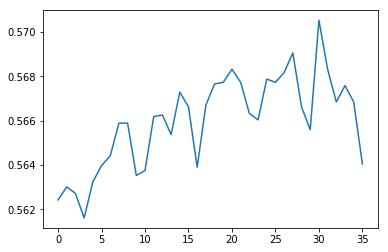

In [184]:
scores = [x[1] for x in gscv.grid_scores_]
#scores = np.array(scores).reshape(len(Cs), len(Gammas))
plt.plot(range(0,len(scores)), scores)
plt.show()

In [10]:
classifier = xgb.XGBClassifier(**get_xgb_params())
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=4.3, learning_rate=0.005, max_delta_step=0, max_depth=3,
       min_child_weight=8, missing=None, n_estimators=74, nthread=-1,
       objective='multi:softprob', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=0.75)

In [11]:
#classifier.predict_proba(X_test)
y_pred = classifier.predict(X_test)
print confusion_matrix(y_pred=y_pred, y_true=y_test)
print f1_score(y_test, y_pred, average='weighted')
print accuracy_score(y_true=y_test, y_pred=y_pred)

[[303   0 368]
 [154   1 401]
 [153   0 826]]
0.429623647819
0.512239347235


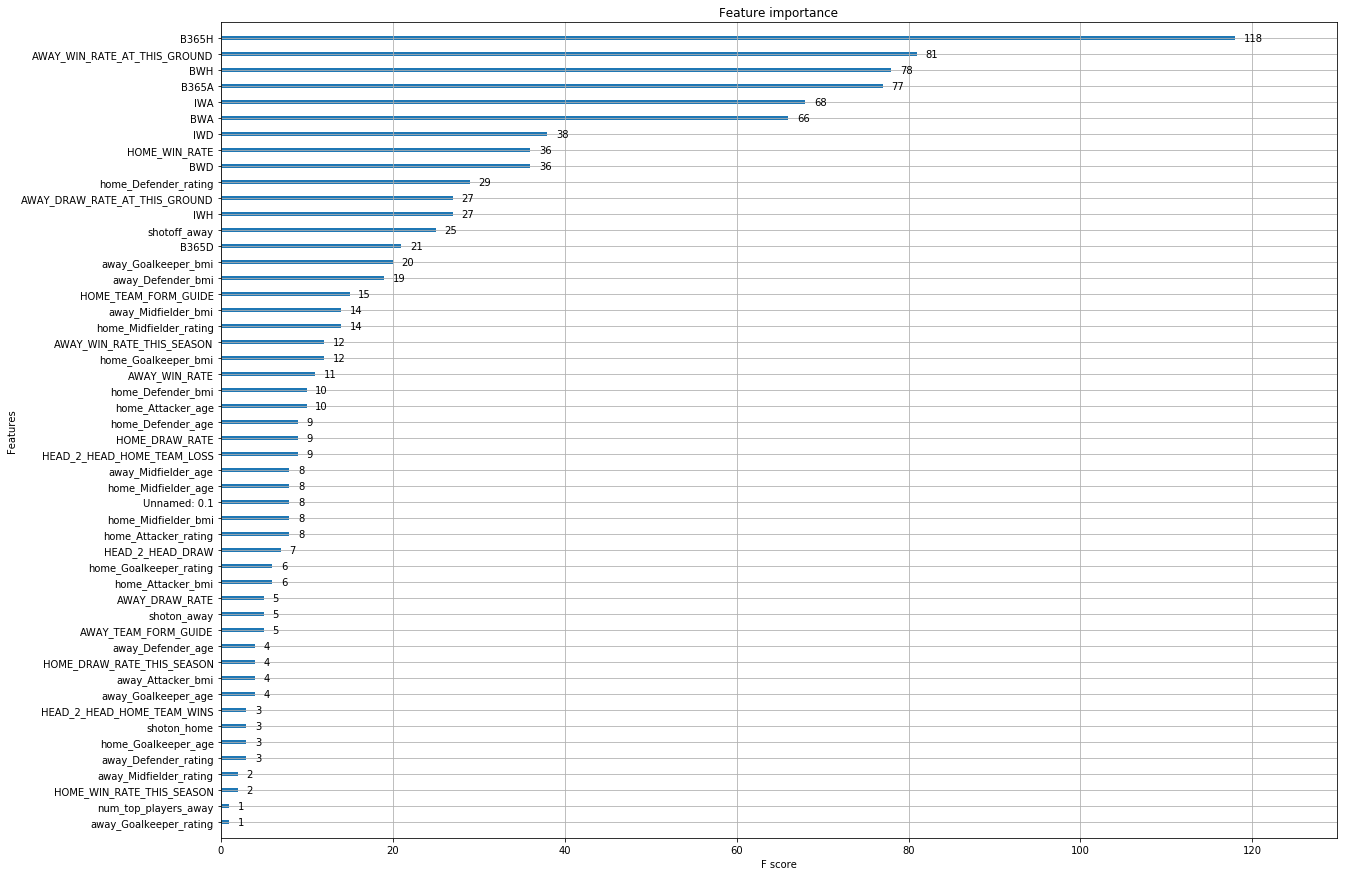

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
xgb.plot_importance(classifier, height=0.25, ax=ax)
plt.show()

In [92]:
y_pred

array([0, 2, 2, ..., 2, 2, 0])

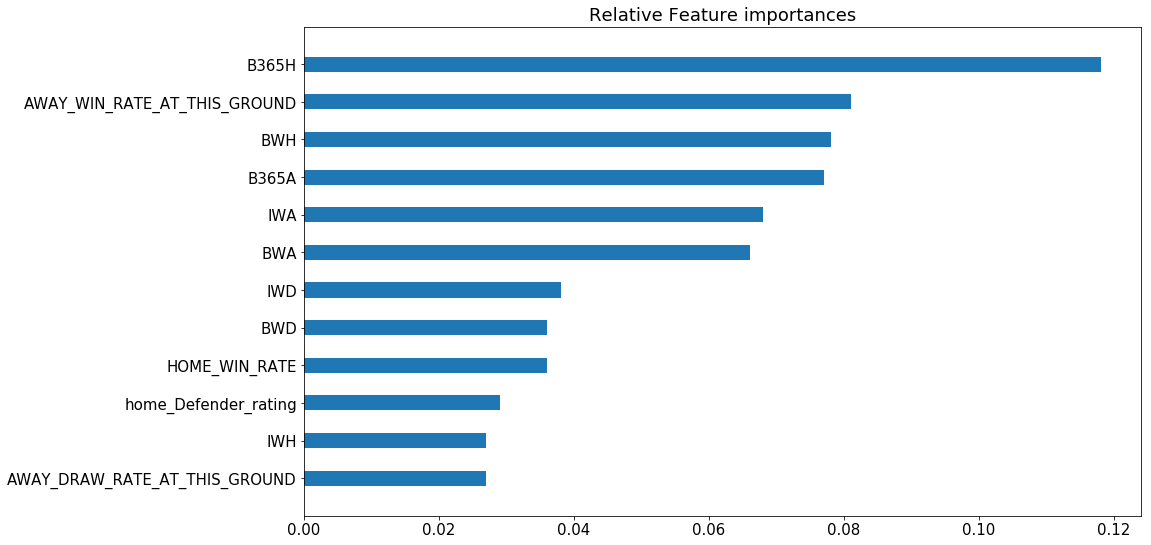

In [14]:
def feat_imp(df, model, n_features):

    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]

    plt.figure(figsize=(15,9))
    plt.title("Relative Feature importances")
    y = [d[i] for i in reversed(top_names)]
    plt.barh(range(n_features), y, align="center",height=0.4)
    plt.ylim(-1, n_features)
    plt.yticks(range(n_features), reversed(top_names), rotation='horizontal')

matplotlib.rcParams.update({'font.size': 15})
feat_imp(X_train,classifier, 12)
plt.show()